In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of gallifrey, before pip installed version, for debugging
import os
import pathlib
import sys

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yt
from matplotlib.ticker import ScalarFormatter

from gallifrey.analysis import count_planets
from gallifrey.model import Model
from gallifrey.utilities.dataframe import (
    rename_labels,
    rename_entries,
    aggregated_dataframe,
)
from gallifrey.utilities.math import calculate_pca
from gallifrey.visualization.visualization_utils import (
    FigureProcessor,
    adjust_legend,
    get_palette,
    ridgeplot,
    set_plot_defaults,
)

## DATA SETUP

In [4]:
snapshot = 127
resolution = 8192
sim_id = "37_11"
num_embryos = 50
host_star_masses = 1
planet_categories = [
    "Earth",
    "Super-Earth",
    "Neptunian",
    "Sub-Giant",
    "Giant",
]

In [5]:
model = Model(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
)
ds = model.ds
mw = model.halo

yt : [INFO     ] 2023-11-26 08:46:11,002 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2023-11-26 08:46:11,155 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2023-11-26 08:46:11,156 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-11-26 08:46:11,158 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-11-26 08:46:11,159 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2023-11-26 08:46:11,160 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-11-26 08:46:11,160 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2023-11-26 08:46:11,161 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2023-11-26 08:46:11,162 Parameters: omega_matter              = 0.318
yt : [INFO     ] 2023-11-26 08:46:11,162 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-11-26 08:46:11,163 Parameters: hubble_constant      

## PLOT SETUP

In [6]:
set_plot_defaults()

figure_subdirectory = f"MilkyWayAnalogue/{model.resolution}/{model.sim_id}/{model.snapshot}/Component_populations"
save = True

## CREATE DATASOURCE

In [7]:
radius = 0.2 * mw.virial_radius()
masses = (0.3, 0.5, 1)
components = ["Bulge", "Thin Disk", "Thick Disk", "Halo"]

sphere = mw.sphere(radius=radius)

## PLANET AGES PER COMPONENT

In [8]:
data = aggregated_dataframe(
    ["bulge_stars", "thin_disk_stars", "thick_disk_stars", "halo_stars"],
    ["stellar_age", *planet_categories],
    data_source=sphere,
    type_name="Component",
    custom_units={"stellar_age": "Gyr"},
)
data = rename_entries(data)

In [9]:
# average planet age
data.groupby("Component").apply(
    lambda x: np.average(
        x["stellar_age"], weights=sum([x[type] for type in planet_categories])
    )
).round(decimals=1)

Component
Bulge         7.6
Halo          8.2
Thick Disk    7.7
Thin Disk     5.8
dtype: float64

In [10]:
# planet age per type
planet_ages = pd.DataFrame(
    [
        data.groupby("Component").apply(
            lambda x: np.average(x["stellar_age"], weights=x[type])
        )
        for type in planet_categories
    ],
    index=planet_categories,
).T
planet_ages.round(decimals=1)

,Earth,Super-Earth,Neptunian,Sub-Giant,Giant
Component,,,,,
Bulge,8.0,7.5,6.8,6.9,6.5
Halo,8.3,8.0,7.3,6.6,6.1
Thick Disk,7.8,7.5,7.2,6.9,6.8
Thin Disk,6.1,5.7,5.1,5.1,4.8


## OCCURENCE RATES PER COMPONENT

In [78]:
occurence_rate_dataframe = {}
for m in masses:
    occurence_rate_dataframe[m] = count_planets(
        model,
        lambda: mw.sphere(radius=radius),
        planet_categories,
        normalize_by="planet_hosting_number",
        model_config={"ngpps_star_masses": m},
        long_format=False,
        value_name="Occurence Rate",
    )

occurence_rate_long_format = {
    m: occurence_rate_dataframe[m].melt(
        id_vars="Component",
        var_name="Planet Type",
        value_name="Occurence Rate",
    )
    for m in masses
}


      CONFIG: Setting ngpps_star_masses to 0.3.


      TIMER: Block 'Adding Planets...' took 3.6 seconds.


      CONFIG: Setting ngpps_star_masses to 0.5.


      TIMER: Block 'Adding Planets...' took 3.55 seconds.


      CONFIG: Setting ngpps_star_masses to 1.


      TIMER: Block 'Adding Planets...' took 3.39 seconds.



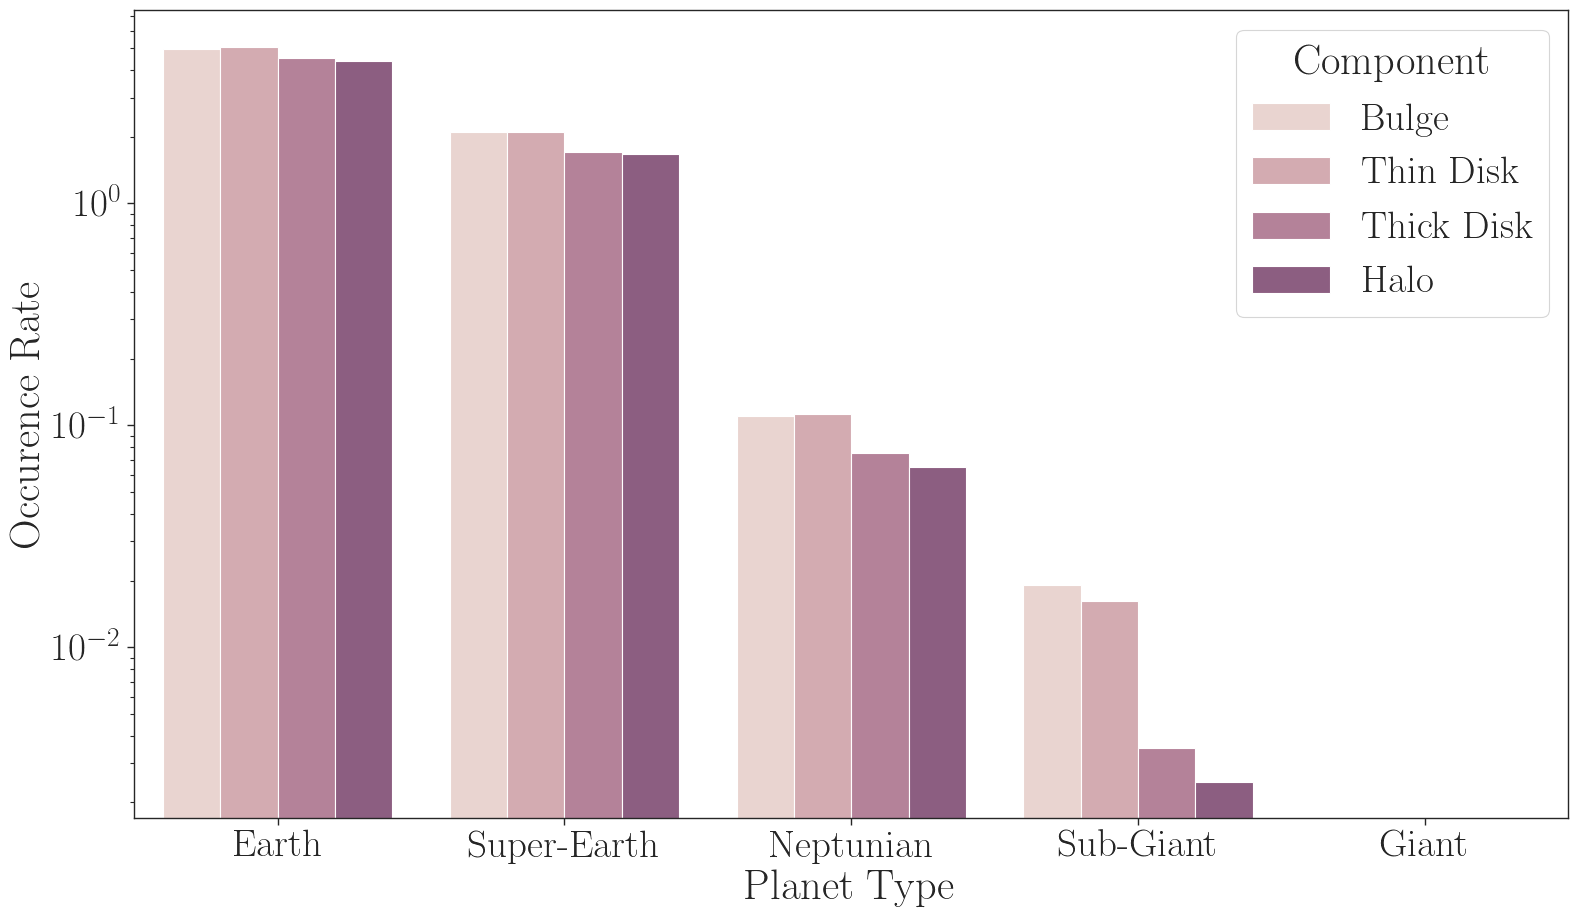

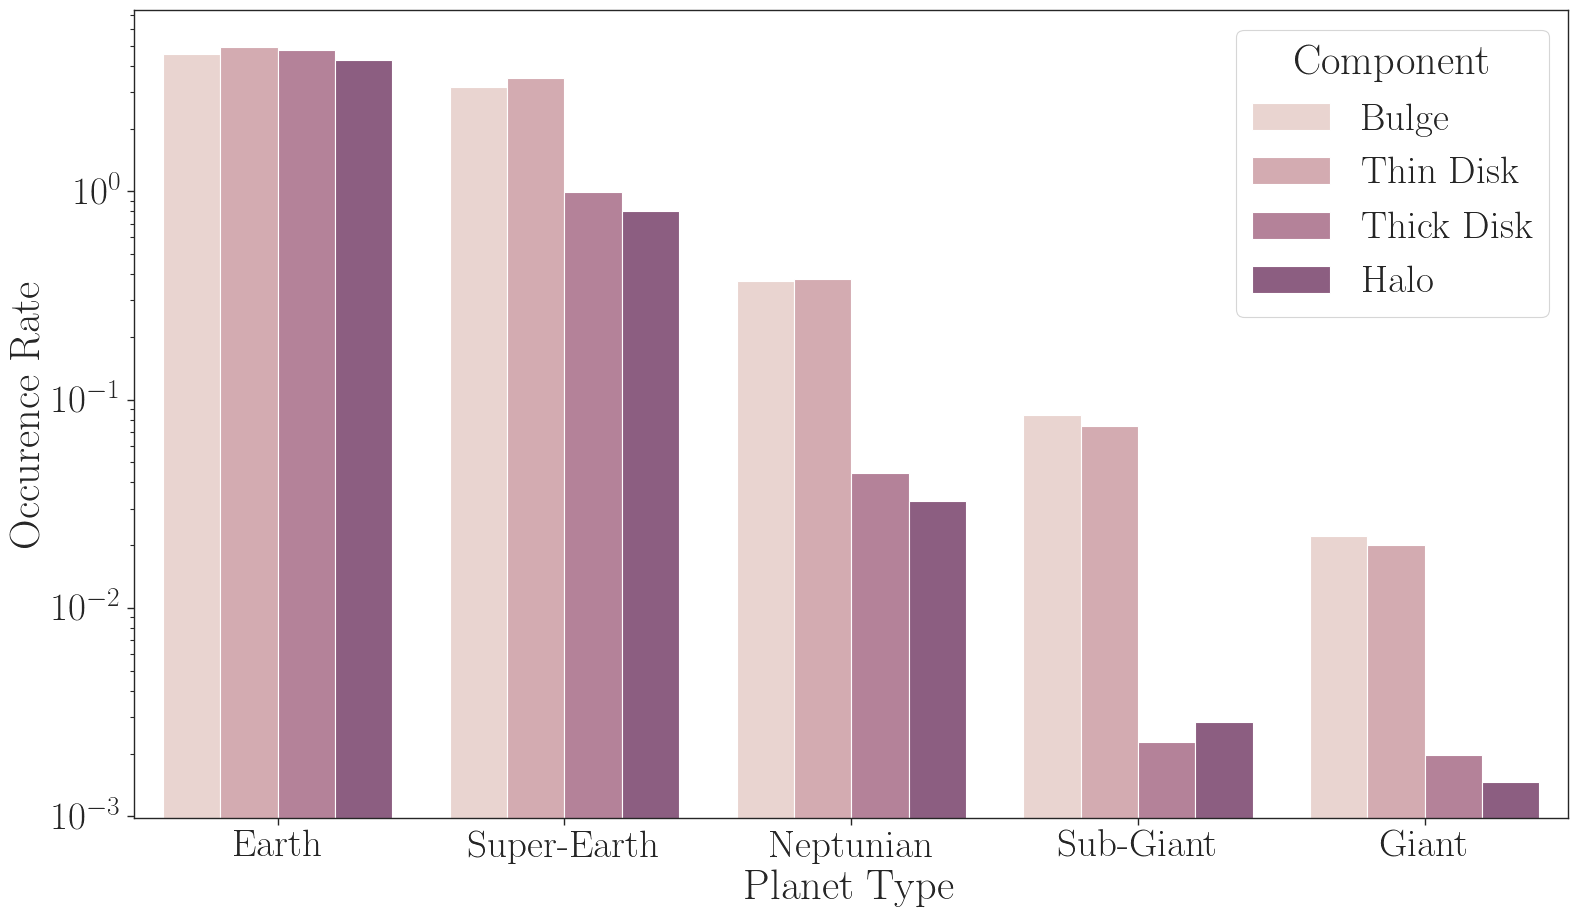

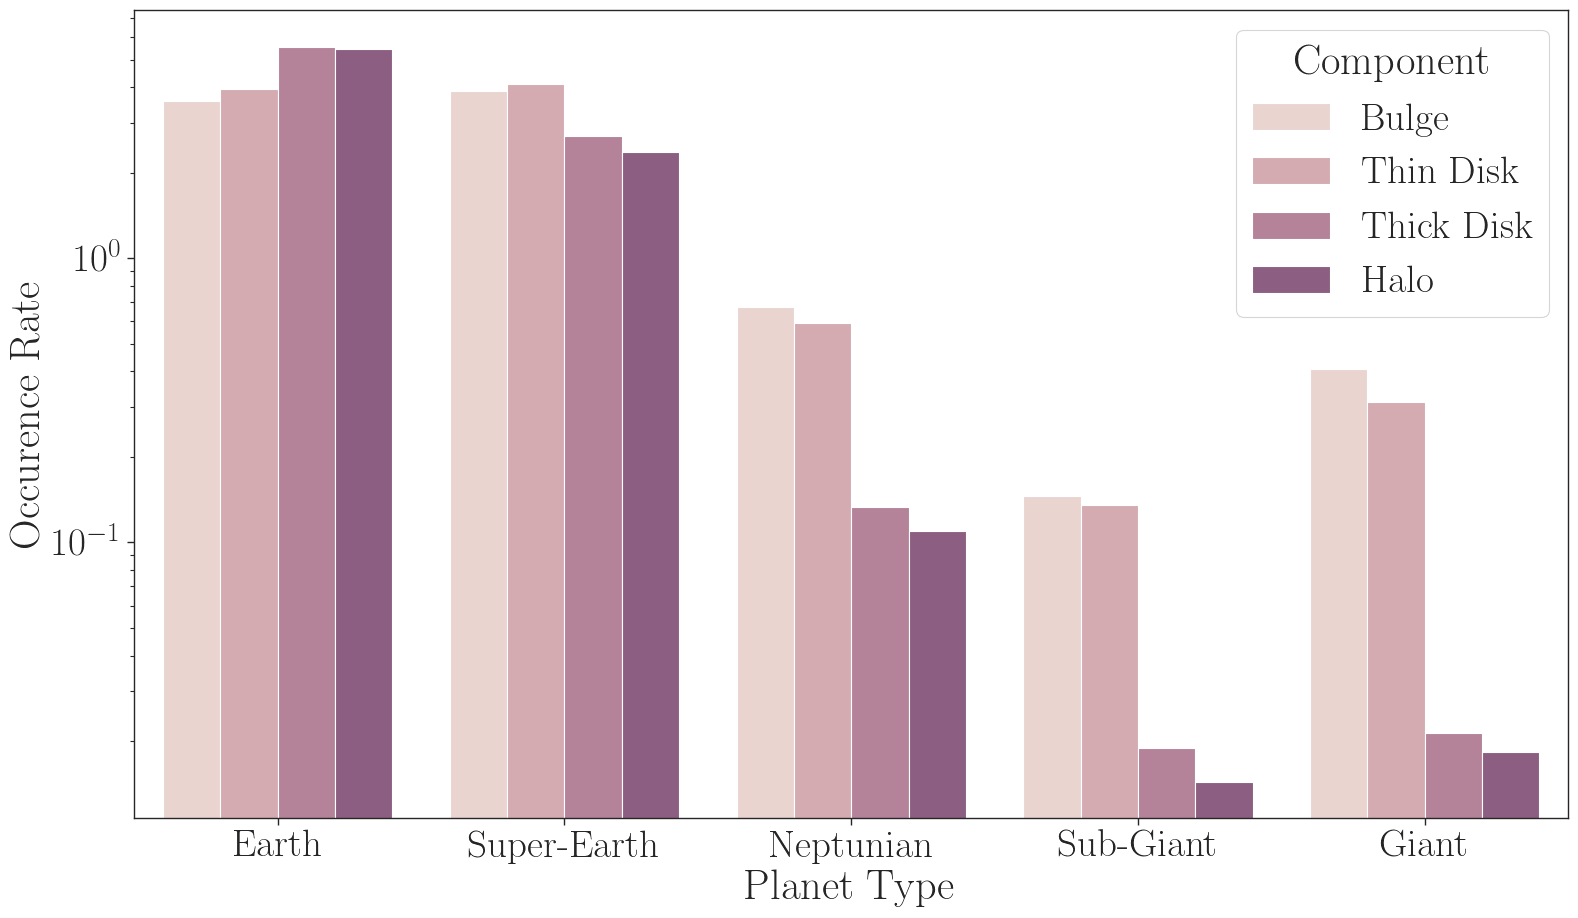

In [12]:
def barplot(occurence_rate_long_format, host_star_mass):
    plt.figure()
    with sns.axes_style("ticks"):
        occurence_rate_barplot = sns.barplot(
            data=occurence_rate_long_format,
            x="Planet Type",
            y="Occurence Rate",
            hue="Component",
            hue_order=components,
            log=True,
            palette=get_palette(),
        )

    FigureProcessor(occurence_rate_barplot.figure).save(
        f"occurence_rates_with_host_star_mass={host_star_mass}.pdf",
        sub_directory=figure_subdirectory,
        save=save,
    )
    return occurence_rate_barplot


for m in masses:
    plot = barplot(occurence_rate_long_format[m], host_star_mass=m)

In [104]:
occurence_rate_combined = {}

for key, value in occurence_rate_dataframe.items():
    dataframe = value.copy()

    # transpose dataframe
    dataframe.set_index("Component", inplace=True)
    dataframe.index.name = None
    dataframe = dataframe.T

    dataframe = dataframe[components]  # reorder columns

    occurence_rate_combined[key] = dataframe

In [109]:
pd.concat(occurence_rate_combined, names=[r"$M_\star$"]).round(decimals=3)

Bulge  Thin Disk  Thick Disk   Halo
$M_\star$                                                 
0.3       Earth        4.958      5.081       4.500  4.393
          Super-Earth  2.091      2.097       1.695  1.676
          Neptunian    0.111      0.113       0.075  0.065
          Sub-Giant    0.019      0.016       0.004  0.002
          Giant        0.000      0.000       0.000  0.000
0.5       Earth        4.565      4.940       4.763  4.288
          Super-Earth  3.171      3.489       0.993  0.808
          Neptunian    0.371      0.379       0.044  0.033
          Sub-Giant    0.085      0.075       0.002  0.003
          Giant        0.022      0.020       0.002  0.001
1.0       Earth        3.558      3.930       5.549  5.439
          Super-Earth  3.866      4.107       2.680  2.358
          Neptunian    0.674      0.592       0.134  0.110
          Sub-Giant    0.146      0.135       0.019  0.014
          Giant        0.406      0.313       0.022  0.018